In [1]:
#Importing necessary Libraries

import keras
from tensorflow.python.keras.layers import Input, Lambda, Dense, Flatten,Dropout,Conv2D
from tensorflow.python.keras.layers import MaxPool2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras import backend as K
import tensorflow as tf
import os
import cv2
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Using TensorFlow backend.


# Read Images and Convert to dataframe

First of all, the images and labels in directory are read and assigned to the list directory.

In [2]:
base_dir = "C:/Users/atulp/Downloads/archive/Vehicles Dataset/data/"

In [3]:

label = []       #  Assign all label
images_path = [] # Get all images path
all_images = []  # Check all images name
idx = 0          # index
img_label = []   # Assign image label



for directory in os.listdir(base_dir):
    label.append(directory)
    for img in os.listdir(os.path.join(base_dir,directory)):
        if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
            img_path = os.path.join(os.path.join(base_dir,directory),img)
            all_images.append(img)
            images_path.append(img_path)
            img_label.append(directory)


### Check Total Data, label and shape of each images.

In [4]:
img_shape = cv2.imread(images_path[0])

print(f"Labels : { label}")
print(f"Total Images : {len(all_images)}")
print(f" Images shape : {img_shape.shape}")

Labels : ['non-vehicles', 'vehicles']
Total Images : 17760
 Images shape : (64, 64, 3)


### Convert to dataframe using pandas framework

In [5]:
data =pd.DataFrame({'image':images_path,'label':img_label}) 
data

,image,label
0,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
1,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
2,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
3,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
4,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
...,...,...
17755,C:/Users/atulp/Downloads/archive/Vehicles Data...,vehicles
17756,C:/Users/atulp/Downloads/archive/Vehicles Data...,vehicles
17757,C:/Users/atulp/Downloads/archive/Vehicles Data...,vehicles
17758,C:/Users/atulp/Downloads/archive/Vehicles Data...,vehicles


### Shuffling dataset distribution

In [6]:
data = data.sample(frac=1).reset_index()
data.head()

,index,image,label
0,8756,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
1,7059,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
2,6870,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
3,4514,C:/Users/atulp/Downloads/archive/Vehicles Data...,non-vehicles
4,11281,C:/Users/atulp/Downloads/archive/Vehicles Data...,vehicles


### Plotting first eight images.

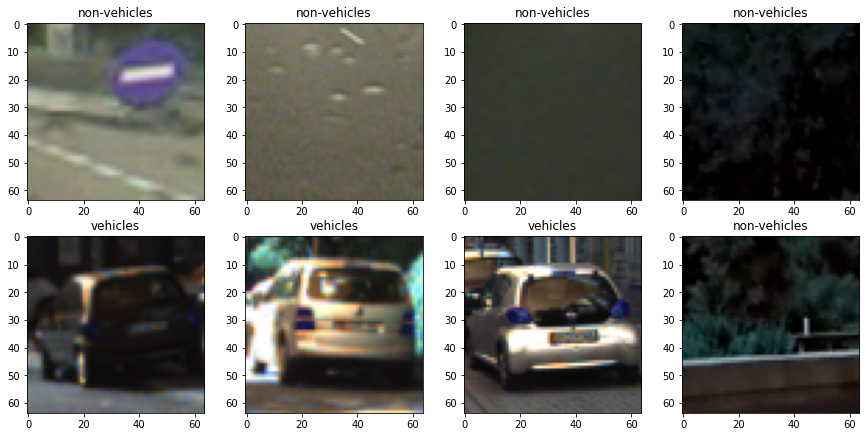

In [7]:
fig = plt.figure(figsize=(15,15))

for i in range(8):
    fig.add_subplot(4,4,i+1).set_title(data['label'][i])
    img = cv2.imread(data['image'][i])
    plt.imshow(img)
    
plt.show()

### Splitting the data to data training and data testing

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(data,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)

(14208, 3)
(3552, 3)


# Data Augmentation Part

It is a set of techniques to artificially increase the dataset by modifying the exact copies of existing data or synthetically generating new copies of the dataset by using existing dataset. Data augmentation is used for training purpose only not for the testing set. 

These are the methods or parameters:

1) Shear range
2) Zoom range
3) rotation range
4) width shift range
5) height shift range
6) horizontal flip
7) validation split


In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

### Data augmentation being implemented to training set, validation set and testing set.

In [10]:
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils.np_utils import to_categorical

training_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

validation_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (224, 224),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

test_set = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = "image",
    y_col = "label",
    target_size = (224, 224),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


#### Checking total images 

In [11]:
print(f" Total training images {X_train.shape[0]}")
print(f" Total test images {X_test.shape[0]}")

print(f" Train Set Size : {(training_set.samples)}")
print(f" Validation Set Size : {(validation_set.samples)}")
print(f" Testing Set Size : {(test_set.samples)}")

 Total training images 14208
 Total test images 3552
 Train Set Size : 11367
 Validation Set Size : 2841
 Testing Set Size : 3552


# Defining the Model

Only two types of classes—vehicle or without—are apparent from the data. We can use sigmoid or softmax as output layers for a two-class problem. To represent each class in this notebook, we utilise a softmax with a two-neuron output. The pre-trained model will be called to classify Stroke or Normal. So, here it is a binary classification problem with 2 categories Non-vehicles and vehicles. In the last layer of the model, changes have to be made according to the number of classes. We use Flatten layer, dense layer and activation function used is softmax. Then we come to know about the model summary.

In [12]:
from tensorflow.python.keras.applications.vgg19 import VGG19
IMAGE_SIZE = [224, 224]

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

In [13]:
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### There are various optimizers but adam optimizer are used a lot nowadays and loss categorical crossentropy because we use softmax.

In [14]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["acc"])

In [15]:
#early_stopping is used to stop training if the accuracy of model won't get high.

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

# Training the model 

For deep learning to work well on a specific task,selecting the appropriate optimizer is essential. We train the model with early stopping callback function. We also use validation set as validation data.

In [16]:
import tensorflow as tf
with tf.device("cpu:0"):
    history = model.fit(training_set, 
                        epochs=10, 
                        validation_data = validation_set, 
                        callbacks=[early_stopping]
                        )

Epoch 1/10
356/356 [==============================] - 1439s 4s/step - loss: 0.1690 - acc: 0.9365 - val_loss: 0.1112 - val_acc: 0.9535
Epoch 2/10
356/356 [==============================] - 1354s 4s/step - loss: 0.0883 - acc: 0.9662 - val_loss: 0.0597 - val_acc: 0.9778
Epoch 3/10
356/356 [==============================] - 1362s 4s/step - loss: 0.0689 - acc: 0.9752 - val_loss: 0.0823 - val_acc: 0.9704
Epoch 00003: early stopping


# Evaluation of the model

Check the model performance by looking at training accuracy and val accuracy through the line plot.

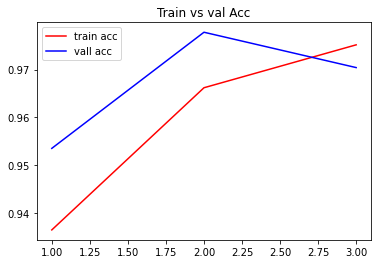

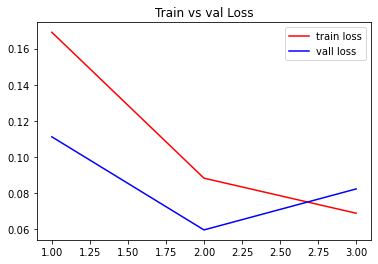

In [17]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)
plt.figure()
plt.title("Train vs val Acc")
plt.plot(epochs,train_acc,'red',label="train acc")
plt.plot(epochs,val_acc,'blue',label="vall acc")
plt.legend()
plt.show()

plt.figure()
plt.title("Train vs val Loss")
plt.plot(epochs,train_loss,'red',label="train loss")
plt.plot(epochs,val_loss,'blue',label="vall loss")
plt.legend()

plt.show()

In [20]:
#Checking accuracy from test_set
test_score = model.evaluate(test_set)

111/111 [==============================] - 381s 3s/step - loss: 0.0335 - acc: 0.9882


In [21]:
#print accuracy scores

print(f'Test Score:{test_score[1]}')
print(f'Test Loss:{test_score[0]}')

Test Score:0.9881756901741028
Test Loss:0.03346208482980728


In [22]:
#Converting predicted labels to array

predicted_label = model.predict(test_set)
predicted_label = np.argmax(predicted_label,axis=1)
predicted_label

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [23]:
#Converting test set labels to array

test_class =test_set.labels
test_class = np.array(test_class)
test_class2 = test_class.flatten()
test_class2

array([0, 1, 0, ..., 0, 1, 1])

In [24]:
class_ind = test_set.class_indices
labels_id = list(class_ind.keys())
labels_id

['non-vehicles', 'vehicles']

## Model performance metrics are called to evaluate the precision, recall, f1-score, accuracy, confusion matrix

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
accuracy_score(test_class2, predicted_label)

0.9881756756756757

In [26]:
recall_score(test_class2, predicted_label)

0.9783599088838268

In [27]:
f1_score(test_class2, predicted_label)

0.9879240943070731

In [28]:
precision_score(test_class2, predicted_label)

0.9976771196283392

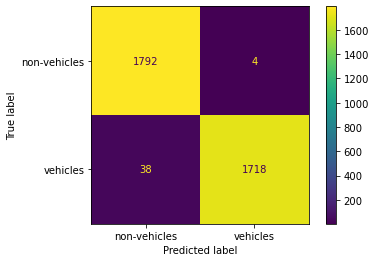

In [31]:

confusion_data = confusion_matrix(test_class2,predicted_label)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_data, display_labels = labels_id)

cm_display.plot()
plt.show()